Цель задания: научиться использовать в коде различные методы Transfer Learning.

Задание:
На примере датасета персонажей мультфильма Симпсонов:

Модифицируйте код обучения, используя различные типы LR Schedulers из Pytorch. Проведите минимум 2 эксперимента с разными шедулерами.  

Подберите аугментации train данных, при которых итоговое качество на валидации станет сильно хуже, чем полученное на занятии.  

Возьмите любую архитектуру (VGG, EfficientNet или MobileNet) и примените к ней методы, которые разбирались на занятии.  

Оформите вывод по результатам проведённых экспериментов.
Формат сдачи работы  

Критерии оценивания
По итогу выполнения задания вы получите - зачёт/незачёт.

Задание считается выполненным, если:

LR Schedulers применяются корректно, проведено 2 эксперимента
при изменении аугментацией Accuracy сильно (> 10 процентов) уменьшилась
корректно проведено обучение и дообучение любой сети (VGG, EfficientNet или MobileNet), получены сравнимые результаты или лучше по сравнению с практикой на занятии
итоговый вывод содержит подробный корректный анализ проведённых экспериментов  

Задание будет отправлено на доработку, если:  

при встраивании LR шедулеров возникли ошибки/проведено < 2 экспериментов
не удалось подобрать аугментации, сильно снижающие качество изображений/был выбран совсем тривиальный пример
не проведены эксперименты с новой архитектурой сети
вывод не написан/не подробный/содержит фактические ошибки


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import time
import glob

from tqdm.notebook import tqdm
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary

import torchvision
from torchvision import transforms

from IPython.display import clear_output
%matplotlib inline

sns.set(font_scale=1.2)
# # sns.set_style(style='whitegrid')
# device_num = 0
# torch.cuda.set_device(device_num)

abraham_grampa_simpson, charles_montgomery_burns, milhouse_van_houten

In [4]:
# разделим картинки на train и val в отношении 70 на 30 для каждого класса
#data_dir = "data/simpsons_dataset"
data_dir = "/content/drive/MyDrive/data/simpsons_dataset_small" # ограничимся 3 классами для ускорения
data_image_paths = glob.glob(f"{data_dir}/*/*.jpg")
data_image_labels = [path.split('/')[-2] for path in data_image_paths]
train_files_path, val_files_path = train_test_split(
    data_image_paths,
    test_size=0.3,
    stratify=data_image_labels
)

print(
    f"Изображений в train: {len(train_files_path)}\nИзображений в val: {len(val_files_path)}"
)

Изображений в train: 2229
Изображений в val: 956


In [5]:
input_size = 224

train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ColorJitter(0.9, 0.9, 0.9),
    transforms.RandomAffine(5),
    transforms.ToTensor(),
])


val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=train_transform,
    is_valid_file=lambda x: x in train_files_path
)

val_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=val_transform,
    is_valid_file=lambda x: x in val_files_path
)

In [9]:
print("Количество классов в train: ", len(train_dataset.classes))
print("Количество классов в val: ", len(val_dataset.classes))
print("Количество классов одинаково: ", len(train_dataset.classes) == len(val_dataset.classes))

Количество классов в train:  3
Количество классов в val:  3
Количество классов одинаково:  True


In [10]:
sns.set_style(style='white')

def show_images(dataset):
    fig, ax = plt.subplots(
        nrows=2, ncols=3, figsize=(8, 6),
        sharey=True, sharex=True
    )

    for fig_x in ax.flatten():
        #idx = np.random.randint(low=0, high=6000)
        idx = np.random.randint(low=0, high=(len(dataset.imgs)-1))
        img, label = dataset[idx]
        fig_x.set_title(dataset.classes[label])
        fig_x.imshow(img.numpy().transpose((1, 2, 0)))

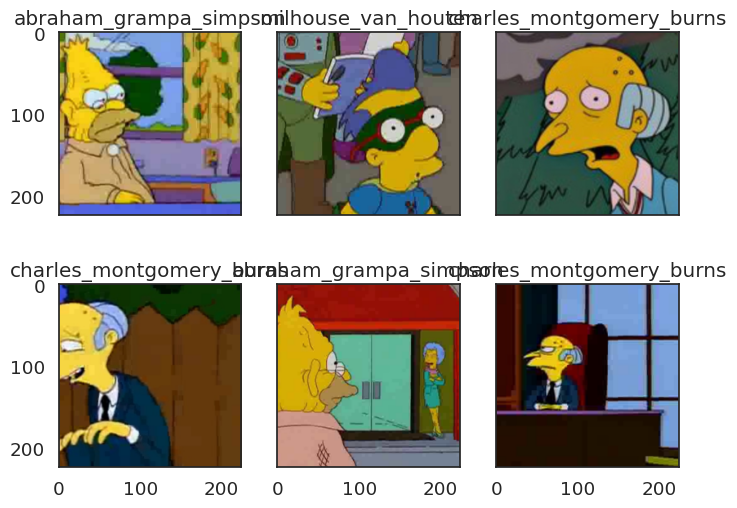

In [11]:
show_images(val_dataset)

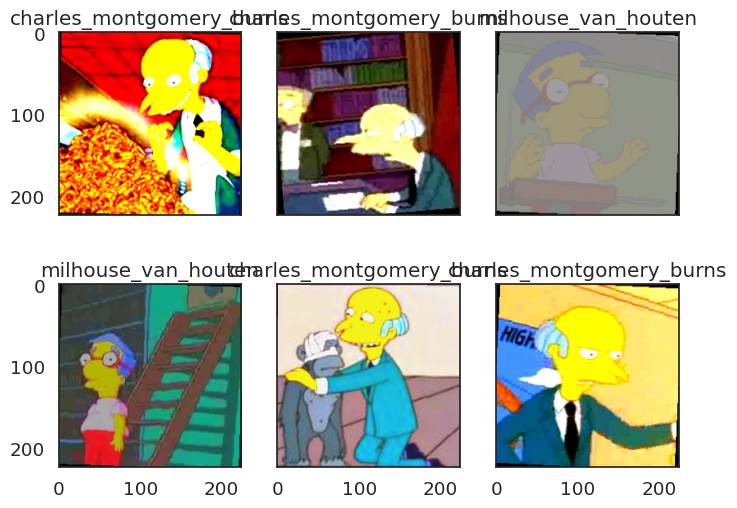

In [12]:
show_images(train_dataset)

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [14]:
def plot_learning_curves(history):
    '''
    Функция для вывода графиков лосса и метрики во время обучения.
    '''
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

In [17]:
def train_scheduler_epoch(
    model,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs=10
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True)

        # на каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # обучаемся на текущем батче
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)

            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)
######### Вызываем шаг шедъюлера после каждой эпохи
        scheduler.step()

        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen)
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)

        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # полностью проходим по валидационному датасету
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy()) # detach() используется на всякий случай, что бы случайно не скопировать вместе с одной цифрой
            y_pred = logits.max(1)[1].detach().cpu().numpy() # все, связанные с ней матрицы градиентов, и не отжирать напрасно память (здесь возможно не нужно, но лучше ставить)
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen)
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)

        clear_output() # чистим предыдущий вывод в консоль, что бы отображался только последний вывод картинок

        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))

        plot_learning_curves(history)

    return model, history

In [20]:
batch_size = 64

# не забудем перемешать train
train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
#train_batch_gen = torch.utils.data.DataLoader(
#    train_dataset_min, batch_size=batch_size, shuffle=True
#)
# валидационный датасет мешать не нужно, а точнее бессмысленно
# сеть на нём не обучается
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)
#val_batch_gen = torch.utils.data.DataLoader(
#    val_dataset_min, batch_size=batch_size, shuffle=False
#)

In [21]:
from torchvision.models import mobilenet_v2

Обучим `mobilenet_v2` с нуля  

In [29]:
model = mobilenet_v2(pretrained=False)

In [30]:
model.classifier = nn.Sequential(
    #nn.Linear(1280, 42),
    nn.Linear(1280, 3),
    nn.LogSoftmax()
)

In [31]:
model = model.to(device)

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [33]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.8)

Epoch 10 of 10 took 504.566s
  training loss (in-iteration): 	0.994489
  validation loss (in-iteration): 	0.912330
  training accuracy: 			49.88 %
  validation accuracy: 			62.15 %


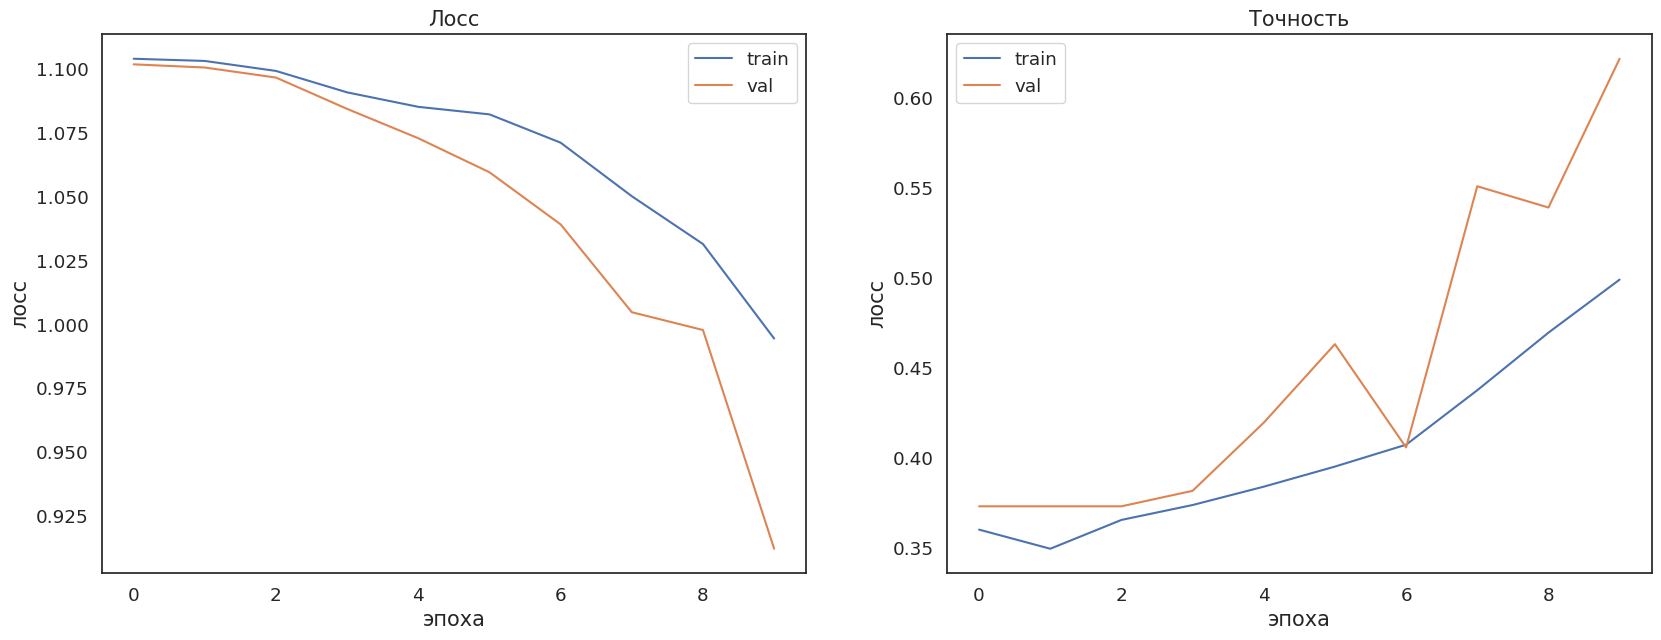

In [34]:
clf_model, history = train_scheduler_epoch(
    model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=10
)

Будем использовать сеть как `Feature Extractor`
<br>
сеть предобученная

Epoch 10 of 10 took 173.565s
  training loss (in-iteration): 	1.584347
  validation loss (in-iteration): 	1.384386
  training accuracy: 			59.69 %
  validation accuracy: 			65.42 %


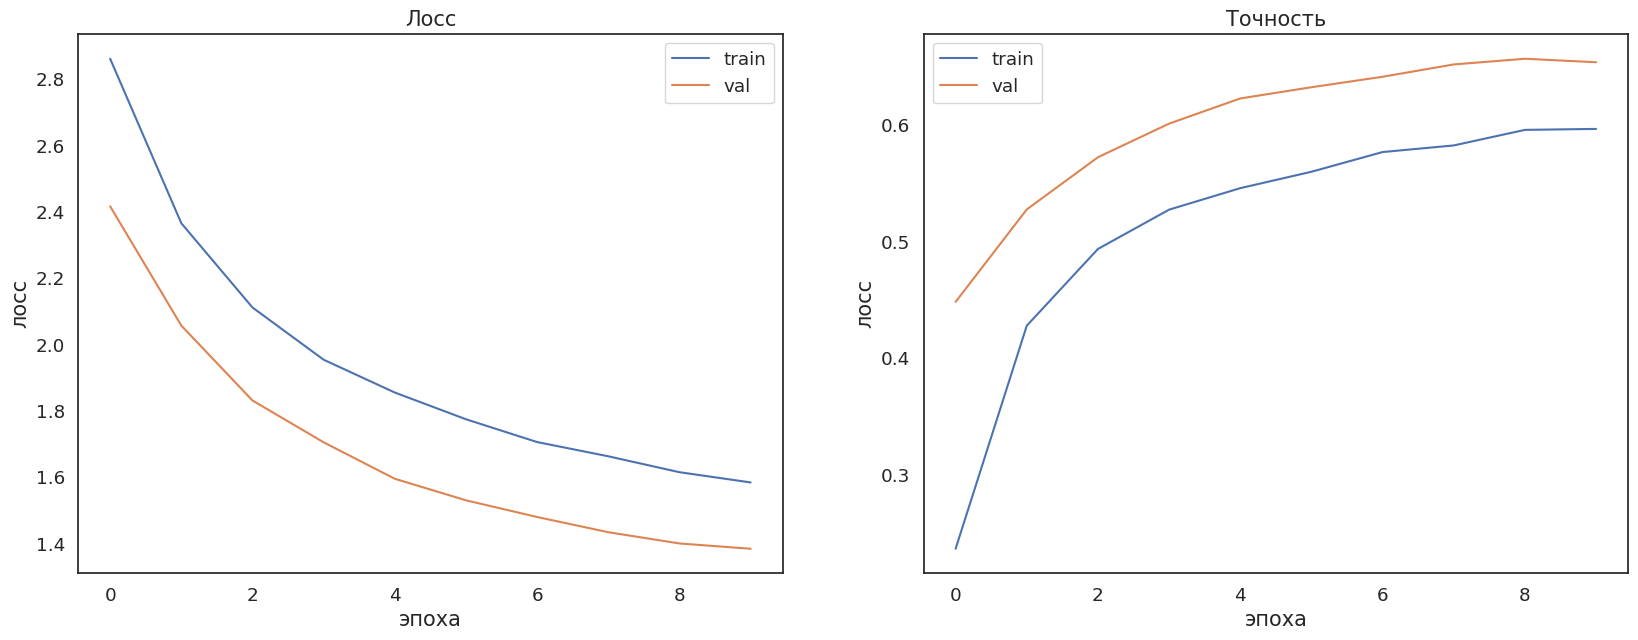

In [ ]:
# возьмём предобученную сеть
fe_model = mobilenet_v2(pretrained=True) # импортируем предобученную сеть

# заморозим все слои сети
for param in fe_model.parameters():
    param.requires_grad = False

# добавим над feature extractor сетью классификационный слой
# на самом деле наверно "заменим"
# градиенты останутся и будут считаться только у этого замененного слоя для классификации
model.classifier = nn.Sequential(
    #nn.Linear(1280, 42),
    nn.Linear(1280, 3),
    nn.LogSoftmax()
)
fe_model = fe_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fe_model.parameters(), lr=0.01)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.8)

clf_model, history = train_scheduler_epoch(
    fe_model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=10
)

Будем использовать как `FineTuning`

Epoch 10 of 10 took 191.909s
  training loss (in-iteration): 	0.095015
  validation loss (in-iteration): 	0.214800
  training accuracy: 			97.50 %
  validation accuracy: 			94.41 %


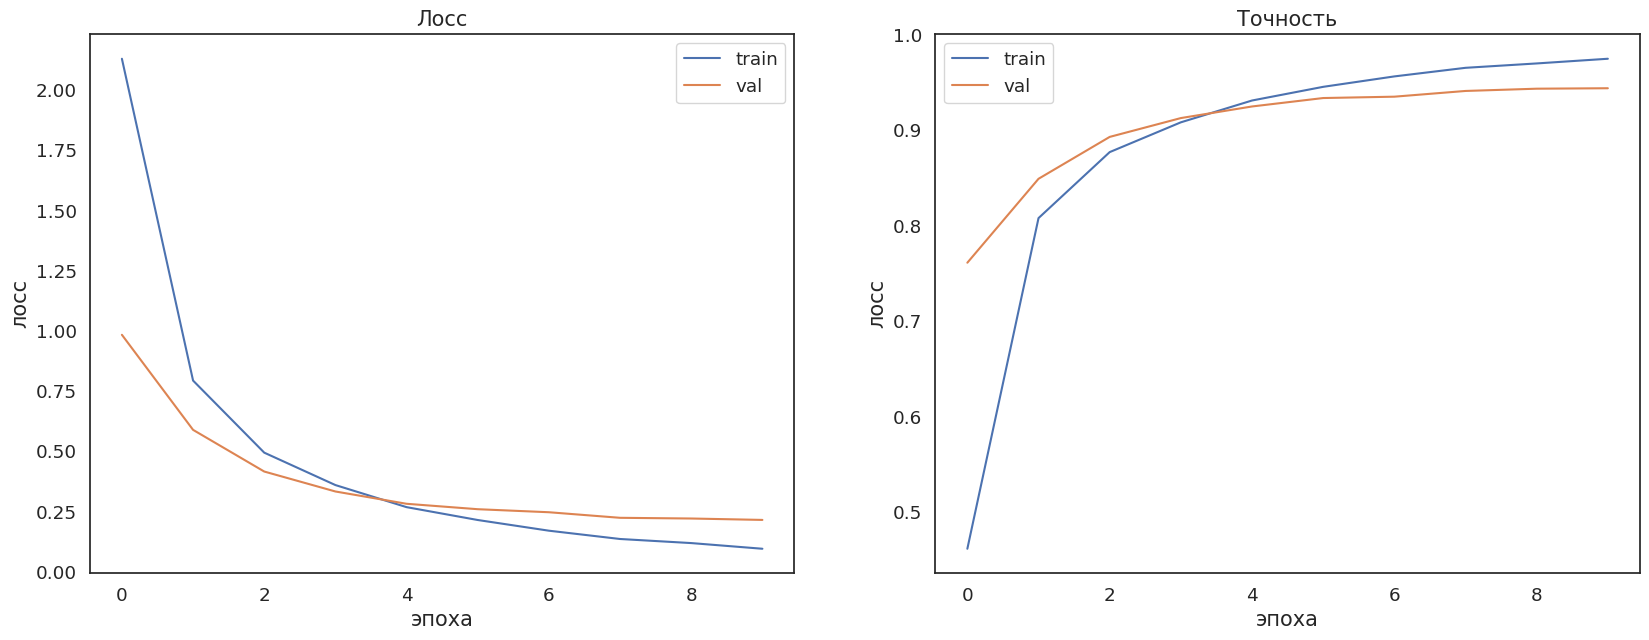

In [ ]:
fine_tuning_model = nn.Sequential()

fine_tuning_model.add_module('mobilenet_v2', mobilenet_v2(pretrained=True))

# добавим новые слои для классификации для нашей конкретной задачи
# Всю сетку оставили не трогая, даже полносвязный слой на 1000 классов,
# а повер нее достроили еще два полносвязных слоя, что бы выйти в конечном итоге
# на наши 42 класса (еще одну голову добавили)
# дообучаться будут все слои в этой предобученной сети

fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
#fine_tuning_model.add_module('fc_2', nn.Linear(512, 42))
fine_tuning_model.add_module('fc_2', nn.Linear(512, 3))

fine_tuning_model = fine_tuning_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.8)

clf_model, history = train_scheduler_epoch(
    fine_tuning_model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=10
)


> Вполне предсказуемо, обучать с нуля большую модель достаточно тяжело, тем более на обрезанном датасете, но при большем времени и при расширенной выборке можно добиться хорошего результата.  



> Извлечение признаков на таком особенном мультяшном домене работает не очень, и надежды на улучшение нет.


> FineTuning, как и должно быть, работает прекрасно.








